In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# metrics

In [2]:
def nonzero_args_length(func):
  def wrap(*args):
    for arg in args:
      if hasattr(arg, '__len__') and not len(arg):
        return 0
    return func(*args)
  return wrap

class Metrics:
  """ Класс с метриками """
  @staticmethod
  @nonzero_args_length
  def MSE(y_pred, y_true):
    return ((y_true - y_pred) ** 2).mean()

  @staticmethod
  @nonzero_args_length
  def logloss(p_pred, p_true, eps=1e-15):
    p_pred = np.clip(p_pred, eps, 1 - eps)
    return -np.mean(p_true * np.log(p_pred) + (1.0 - p_true) * np.log(1.0 - p_pred))

  @staticmethod
  @nonzero_args_length
  def R2(y_pred, y_true):
    return 1 - Metrics.MSE(y_pred, y_true) / y_true.var()

  @staticmethod
  @nonzero_args_length
  def accuracy(y_pred, y_true):
    true_indexes = (y_pred == y_true)
    return y_pred[true_indexes].size / y_true[true_indexes].size

  @staticmethod
  @nonzero_args_length
  def error_matrix(y_pred, y_true, klass=1):
    kl_cond = (y_true == klass)
    true_cond = y_pred == y_true
    TP = y_pred[true_cond & kl_cond].size
    TN = y_pred[true_cond & ~kl_cond].size
    FP = y_pred[~true_cond & ~kl_cond].size
    FN = y_pred[~true_cond & kl_cond].size
    return np.array([[TP, FP],
                    [FN, TN]])

  @staticmethod
  @nonzero_args_length
  def precision(y_pred, y_true, klass=1):
    ma = Metrics.error_matrix(y_pred, y_true, klass)
    return ma[0, 0] / (ma[0, 0] + ma[0, 1])

  @staticmethod
  @nonzero_args_length
  def recall(y_pred, y_true, klass=1):
    ma = Metrics.error_matrix(y_pred, y_true, klass)
    return ma[0, 0] / (ma[0, 0] + ma[1, 0])

  @staticmethod
  @nonzero_args_length
  def f1_score(y_pred, y_true, klass=1, beta=1):
    return (1 + beta ** 2) * Metrics.precision(y_pred, y_true, klass) * Metrics.recall(y_pred, y_true, klass) / ((beta ** 2) * Metrics.precision(y_pred, y_true, klass) + Metrics.recall(y_pred, y_true, klass))

# core

## dependencies

In [3]:
def recast_args(*, n: int = 0, originals: list = (), target=np.array):
  """ Cast first n arguments to given type """
  def _decorator(func):
    def wrapper(self, *args, **kwargs):
      recasted = [target(arg) if type(arg) in originals else arg for arg in args[:n]]
      recasted.extend(args[n:])
      return func(self, *recasted, **kwargs)
    return wrapper
  return _decorator

In [4]:
class DefDict(dict):
  def __getitem__(self, key):
    if key not in self.keys():
      self[key] = 0
    return self.get(key)


class ClassCounter(DefDict):
  """ Счетчик классов """
  def __init__(self, iterable):
    super().__init__()
    self.__size = len(iterable)
    for item in iterable:
      self[item] += 1

  @property
  def most_frequent(self):
    return max(self, key=self.get)
  
  @property
  def values(self):
    return np.array(list(super().values()))
    # return np.array([self[key] for key in sorted(self.keys())])     # если вдруг понадобятся отсортированные по классам
  
  @property
  def proba(self):
    """ Вероятности по каждому классу """
    return DefDict({k: v / self.__size for k, v in self.items()})


In [5]:
class Criteria:
  """ Набор критериев информативности """
  @staticmethod
  def variance(values: np.array):
    """ Дисперсия """    
    return values.var() if values.size else 0
  
  @staticmethod
  def gini(values: np.array):
    """ Критерий Джини """
    classes = ClassCounter(values).values
    p = classes / classes.sum()
    return 1 - (p ** 2).sum() if p.size else 0
  
  @staticmethod
  def entropy(values: np.array, eps=1e-15):
    """ Энтропия Шеннона """
    classes = ClassCounter(values).values
    p = np.clip(classes / classes.sum(), eps, 1 - eps)
    return -np.sum(p * np.log2(p))

In [6]:
class Predictor:
  """ Набор функций получения предсказаний из листа 
  return types:
    для регрессии возвращаемое значение должно быть float
    для классификации возвращаемое значение должно быть dict с вероятностями классов
  """
  def __init__(self, rs=None):
    self.rs = rs

  @staticmethod
  def regress_average_mean(values):
    """ Функция усреднения предсказаний для регрессии
    :param type - np.array[float]
    :return type float
    """
    return np.mean(values)

  def regress_average_median(values):
    """ Функция усреднения предсказаний для регрессии
    :param type - np.array[float]
    :return type float
    """
    return np.median(values)

  @staticmethod
  def class_average_mean(values):
    """ Функция усреднения предсказаний для классификации
    :param type - np.array[dict(klass: probability)]
    :return type dict(klass: probability)
    """
    avg_proba = DefDict()
    for element in values:
      for klass, proba in element.items():
        avg_proba[klass] += proba
    return {kl: pr / values.size for kl, pr in avg_proba.items()}

  @staticmethod
  def regress_mean(leaf_values, data=None):
    return lambda x: np.mean(leaf_values)
  
  @staticmethod
  def regress_median(leaf_values, data=None):
    return lambda x: np.median(leaf_values)
  
  @staticmethod
  def class_proba(leaf_values, true_value):
    """ Вероятности классов """
    return lambda x: ClassCounter(leaf_values).proba

  def regress_linear(self, leaf_values, data):
    """ Линейная модель внутри листа для регрессии """
    def prepare_predict(x):
      x = x.copy()
      # x = (x - means) / stds      # standardize
      x = np.insert(x, 0, 1)
      result = lm.predict(x)
      return result if minimum < result < maximum else mean
      # return np.clip(lm.predict(x), minimum, maximum)
      # return lm.predict(x)

    # get statistics and standardize data
    minimum = leaf_values.min()
    maximum = leaf_values.max()
    median = np.median(leaf_values)
    mean =  leaf_values.mean()
    # means = data.mean(axis=0)
    # stds = data.std(axis=0)    
    # X = (data - means) / stds     # из-за одинаковости объектов в листе тут может быть Division by zero

    X = data.copy()
    # if np.isnan(X).any():
    #   print('some X became nan!')

    X = np.insert(X, 0, 1, axis=1)   # add intercept
    # fit
    lm = LinearModel(model_type='regress')
    lm.fit(X, leaf_values, eta=0.1, iterations=250, batch_type='random', batch_size=data.shape[0] // 2, random_state=self.rs)
    # если не удалось построить линейную модель
    if np.isnan(lm.W).any():
      print('W-nan!')
      prepare_predict = lambda x: leaf_values.mean()
    
    return prepare_predict

  def class_linear(self, leaf_values, data):
    """ Линейная модель внутри листа для классификации """
    def prepare_predict(x):
      x = x.copy()
      # x = (x - means) / stds      # standardize
      x = np.insert(x, 0, 1)
      p = lm.predict_proba(x)
      p = p if minimum < p < maximum else mean
      return {0: 1 - p, 1: p}
    
    # get statistics
    minimum = leaf_values.min()
    maximum = leaf_values.max()
    median = np.median(leaf_values)
    mean =  leaf_values.mean()
    # standardize data
    # means = data.mean(axis=0)
    # stds = data.std(axis=0)
    # X = (data - means) / stds     # из-за одинаковости объектов в листе тут может быть Division by zero
    X = data.copy()
    X = np.insert(X, 0, 1, axis=1)   # add intercept
    # fit
    lm = LinearModel(model_type='class')
    lm.fit(X, leaf_values, eta=0.1, iterations=250, random_state=self.rs)
    # если не удалось построить линейную модель
    if np.isnan(lm.W).any():
      print('W-nan!')
      prepare_predict = lambda x: leaf_values.mean()

    return prepare_predict

## linear

In [7]:
class LinearModel:
  def __init__(self, **kwargs):
    self.model_type = kwargs.get('model_type', None)
    if not self.model_type:
      raise ValueError('`model_type` is a required parameter.')
    elif self.model_type not in ['regress', 'class']:
      raise ValueError('`model_type` parameter can be `regress` or `class`')
    self.__calc_error = self.__mse if self.model_type == 'regress' else self.__logloss

    self.errors = []
    self.W = None
  
  @staticmethod
  def __mse(y_pred, y_true):
      """ Calculate MSE """
      return (y_true - y_pred).mean() ** 2

  @staticmethod
  def __logloss(y_pred, y_true, eps=1e-15):
      y_pred = np.clip(y_pred, eps, 1 - eps)
      return -np.mean(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))

  @staticmethod
  def __sigmoid(z):
      return 1 / (1 + np.exp(-z))

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, X, y_true, **kwargs):
    """ Fit the linear model with SGD """
    n = X.shape[0]
    # read parameters
    eta = kwargs.pop('eta', 1e-4)
    eps = kwargs.pop('eps', 1e-8)
    max_iterations = kwargs.pop('max_iterations', 100)
    L1 = kwargs.pop('L1', 0)        # L1 regularization
    L2 = kwargs.pop('L2', 0)        # L2 regularization
    batch_type = kwargs.get('batch_type', 'random')
    batch_size = kwargs.get('batch_size', n)
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)
    if not batch_size:
      print(n)
      raise ValueError('`batch_size` cannot be 0')
    silent = kwargs.get('silent', True)
    
    # fit
    self.W = np.zeros(X.shape[1])
    n_batch = n // batch_size if n % batch_size == 0 else n // batch_size + 1
      
    if not silent:
      print(f'Objects: {n}\nLearning rate: {eta}\nInitial weights: {self.W}\n' \
        f'Batch type: {batch_type}; batch size: {batch_size}; total batches: {n_batch}')
    
    iter = 0
    norm_delta = np.inf
    while (norm_delta > eps) and (iter < max_iterations):
      for batch in range(n_batch):
        if batch_size and (batch_type == 'random'):
          sample_index = self.rng.integers(X.shape[0], size=batch_size)
          X_batch = X[sample_index]
          y_batch = y_true[sample_index]
        else:
          start = batch_size * batch
          end =  batch_size * (batch + 1)
          X_batch = X[start:end]
          y_batch = y_true[start:end]
        
        # calc and append error
        y_pred = self.predict(X)
        err = self.__calc_error(y_pred, y_true)
        self.errors.append(err)
                
        # iterate gradient
        y_batch_pred = X_batch @ self.W
        dQ = 1 / y_batch.shape[0] * X_batch.T @ (y_batch_pred - y_batch)
        dReg = L1 * np.sign(self.W) + L2 * self.W
        self.W -= eta * (dQ + dReg)
        norm_delta = np.linalg.norm(self.W, ord=1)

      iter += 1
      if (iter == 1 or iter % (max_iterations / 10) == 0) and not silent:
        print(f'Iteration: {iter:4d} | Loss = {round(err, 5)}')

      # debug reset
      # if np.isnan(self.W).any():
      #   self.W = np.zeros(X.shape[1])
      #   norm_delta = np.inf
      #   silent = False
      #   eta = eta / 2
      #   iter = 0
        
    if not silent:
      print(f'Iterations: {iter:4d}  | W = {self.W} | Loss = {round(err, 5)}')
          
  def predict_proba(self, X):
    predict = X @ self.W
    if self.model_type == 'class':
      return self.__sigmoid(predict)
    return predict

  def predict(self, X, threshold=0.5):
    predict = self.predict_proba(X)
    if self.model_type == 'class':
      return np.array([int(item > threshold) for item in predict])
    return predict

  def error(self, y_pred, y_true):
    return self.__calc_error(y_true, y_pred)

## basic classes

In [8]:
class Leaf:
  """ Класс листа """
  def __init__(self, data, values, predict_method):
    self.data = data                        # набор исходных признаков в листе
    self.values = values                    # набор целевых значений в листе
    self.predict_method = predict_method    # функция, возвращающая предсказание листа (в простейшем случае возвращает константу)

In [9]:
class Node:
  """ Класс узла """
  def __init__(self, index, threshold, true_branch, false_branch):
    self.index = index                # feature index
    self.threshold = threshold        # condition threshold value
    self.true_branch = true_branch    # branch that match the condition
    self.false_branch = false_branch  # branch that does not match the condition

In [10]:
class Ensemble:
  def __init__(self, **kwargs):
    # basic ensemble parameters
    self.ensemble = []
    self.bootstraps = []
    self.weights = []
    self.BasicTree = kwargs.get('basic_tree_class')
    self.basic_tree_params = kwargs.get('basic_tree_params', {})

## decision tree

In [11]:
class DecisionTree():
  def __init__(self, **kwargs):
    """
    :param criteria - функция критерия информативности (impurity function)
    :param predictor - функция получения предсказаний из листа (см. описание класса Predictor)
    """
    self.criteria = kwargs.get('criteria')      # критерий информативности
    self.predictor = kwargs.get('predictor')    # функция расчета предсказаний в листе

    self.__leafs = 0
    self.__max_leafs = np.inf
    self.__depth = 0
    self.tree = None

  def iter_average(self, values):
    """ Генератор среднего между текущим и следующим значением в выборке """
    iterator = iter(values)
    try:      
      elem = next(iterator)
      next_elem = next(iterator)
      while next_elem:
        yield np.mean(elem + next_elem)   # для 2ух значений mean и median одинаковые, так что тут смысла указывать функцию немного. разве что можно извращаться со средним гармоническим итп
        elem = next_elem
        next_elem = next(iterator)
    except StopIteration:
      pass

  def choice_features(self, features_count):
    """ Генерация индексов признаков для разделения подпространств """
    return self.rng.choice(features_count, size=features_count, replace=False)    # заглушка "от дурака". Реализация в потомках

  def gain(self, left_values, right_values, root_criteria):
    """ Расчет информационного прироста """
    p = left_values.shape[0] / (left_values.shape[0] + right_values.shape[0])
    return root_criteria - p * self.criteria(left_values) - (1 - p) * self.criteria(right_values)

  @staticmethod
  def split(data, values, column_index, threshold):
    """ Разбиение датасета в узле """
    condition = data[:, column_index] <= threshold
    true_data = data[condition]
    false_data = data[~condition]
    true_values = values[condition]
    false_values = values[~condition]
    return true_data, false_data, true_values, false_values

  def search_best_split(self, data, values, **kwargs):
    """ Нахождение наилучшего разбиения на текущем уровне """
    min_samples_leaf = kwargs.get('min_samples_leaf', None)

    root_criteria = self.criteria(values)
    best_gain = 0
    best_threshold = None
    best_index = None

    # выбор случайных признаков на уровне постановки вопросов
    features_indexes = kwargs.get('features')
    if features_indexes == 'choice_on_split':
      features_indexes = self.choice_features(data.shape[1])      # выбираем случайные признаки

    for index in features_indexes:
      # NaN processing
      clean_data_index = ~np.isnan(data[:, index])
      clean_data = data[clean_data_index]

      unique_thresholds = np.unique(clean_data[:, index])
      for threshold in self.iter_average(unique_thresholds):
        # ask question and split data
        true_data, false_data, true_values, false_values = self.split(clean_data, values, index, threshold)

        # skip if leaf length < min_samples_leaf
        if min_samples_leaf and ((true_data.shape[0] < min_samples_leaf) or (false_data.shape[0] < min_samples_leaf)):
          continue
        
        current_gain = self.gain(true_values, false_values, root_criteria) * clean_data.shape[0] / data.shape[0]
        # store best result
        if current_gain > best_gain:
          best_gain, best_threshold, best_index = current_gain, threshold, index
          true_data = np.append(true_data, data[~clean_data_index], axis=0)
          false_data = np.append(false_data, data[~clean_data_index], axis=0)

    return best_gain, best_threshold, best_index

  def build_tree(self, data, values, **kwargs):
    """ Построение дерева """
    max_depth = kwargs.get('max_depth', np.inf)
    depth = kwargs.pop('depth', None)
    gain_eps = kwargs.get('gain_eps', 0)
    self.__depth = max(self.__depth, depth)

    gain, threshold, index = self.search_best_split(data, values, **kwargs)
    if (gain <= gain_eps) or (depth == max_depth) or (self.__leafs + 2 > self.__max_leafs - self.__depth):     # +2 потому что узел обязан иметь два потомка, -depth чтобы зарезервировать места для листов в false-ветке
      self.__leafs += 1
      leaf_predict_method = self.predictor(values, data)
      return Leaf(data, values, leaf_predict_method)
    # split data
    true_data, false_data, true_values, false_values = self.split(data, values, index, threshold)    
    true_branch = self.build_tree(true_data, true_values, depth=depth + 1, **kwargs)      # recursive build true branch
    false_branch = self.build_tree(false_data, false_values, depth=depth + 1, **kwargs)   # recursive build false branch
    return Node(index, threshold, true_branch, false_branch)

  # без рекаста всплывает KeyError при индексации по условию в search_best_split(), потому что pandas имеет другой синтаксис обращений по индексу
  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Построение дерева
    :param features - используемые признаки. Можно задать списком с индексами признаков, также допустимо `choice_on_start`, `choice_on_split`,
                      в остальных случаях (по умолчанию) - используются все признаки
    :param min_samples_leaf - минимальное кол-во объектов в листе
    :param max_depth - максимальный уровень дочерних элементов дерева
    :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
    :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
    """
    if {'depth'}.intersection(kwargs.keys()):
      raise ValueError('Invalid parameters')
    min_samples_leaf = kwargs.get('min_samples_leaf', 1)
    if ('linear' in self.predictor.__name__) and (min_samples_leaf == 1):
      raise ValueError('min_samples_leaf cannot be 1 with linear leaf predictor.')
      
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)

    # reinitialize basic tree parameters
    self.__max_leafs = kwargs.pop('max_leafs', np.inf)
    self.__leafs = 0
    self.__depth = 0

    # выбор случайных признаков для обучения на старте обучения
    features_indexes = kwargs.pop('features', range(data.shape[1]))
    if (features_indexes == 'choice_on_start'):
      features_indexes = self.choice_features(data.shape[1])      # выбираем случайные признаки
    # build tree
    self.tree = self.build_tree(data, values, depth=0, features=features_indexes, **kwargs)

  def classify(self, obj, node):
    """ Обход дерева вглубь в поиске предсказания """
    if isinstance(node, Leaf):
      return node.predict_method(obj)    
    node = node.true_branch if obj[node.index] <= node.threshold else node.false_branch   # сравнение признака объекта по условию в узле и проход к следующему узлу
    return self.classify(obj, node)
  
  @property
  def leafs(self):
    return self.__leafs
  
  @property
  def depth(self):
    return self.__depth

In [12]:
class RegressDecisionTree(DecisionTree):
  def __init__(self, **kwargs):
    kw = {}
    kw['criteria'] = kwargs.get('criteria', Criteria.variance)
    kw['predictor'] = kwargs.get('predictor', Predictor.regress_mean)    # функция расчета предсказаний в листе
    super().__init__(**kw)

  def choice_features(self, features_count):
    size = np.ceil(features_count / 3).astype(np.int64)
    return self.rng.choice(features_count, size=size, replace=False)

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значений для набора объектов """
    return np.array([self.classify(obj, self.tree) for obj in data]) * weight

In [13]:
class ClassDecisionTree(DecisionTree):
  def __init__(self, **kwargs):
    kw = {}
    kw['criteria'] = kwargs.get('criteria', Criteria.gini)
    kw['predictor'] = kwargs.get('predictor', Predictor.class_proba)    # функция расчета предсказаний в листе
    super().__init__(**kw)

  def choice_features(self, features_count):
    size = np.ceil(np.sqrt(features_count)).astype(np.int64)
    return self.rng.choice(features_count, size=size, replace=False)

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict_proba(self, data, weight=1):
    """ Предсказание взвешенной вероятности классов для набора объектов """
    return np.array([{k: v * weight for k, v in self.classify(obj, self.tree).items()} for obj in data])
  
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значений для набора объектов """
    return np.array([int(max(probas, key=probas.get)) for probas in self.predict_proba(data, weight)])

## boosted decision tree

In [14]:
class BoostedRegressTree(Ensemble):
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', RegressDecisionTree)
    super().__init__(**kwargs)

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Бустинг дерева - регрессия
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов исходного дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param random_state
    """
    # read params
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)    
    trees = kwargs.pop('trees', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 1)
    self.eta = kwargs.pop('eta', 0.2)
    max_depth = kwargs.pop('max_depth', np.inf)
    boost_depth = kwargs.pop('boost_depth', np.inf)

    # сгенерировать бутстрапированные выборки
    target = np.zeros(values.shape, dtype=np.float64)
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_t = values[self.bootstraps[i]] - target[self.bootstraps[i]]

      # построение дерева
      dtree = self.BasicTree(**self.basic_tree_params)      
      dtree.fit(bootstrap_X, bootstrap_t, max_depth=boost_depth if i else max_depth,
                features='choice_on_split', min_samples_leaf=min_samples_leaf, **kwargs)
      self.ensemble.append(dtree)
      target = target + self.eta * dtree.predict(data)
    
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание значения """
    return self.eta * weight * np.sum([tree.predict(data) for tree in self.ensemble], axis=0)

In [15]:
class BoostedClassTree(Ensemble):
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', ClassDecisionTree)
    super().__init__(**kwargs)
    self.classes_count = 2

  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)
  def fit(self, data, values, **kwargs):
    """ Бустинг дерева - классификация
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов исходного дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param random_state
    """
    # read params
    rs = kwargs.get('random_state', None)
    self.rng = np.random.default_rng(rs)    
    trees = kwargs.pop('trees', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 1)
    max_depth = kwargs.pop('max_depth', np.inf)
    boost_depth = kwargs.pop('boost_depth', np.inf)

    self.classes_count = np.unique(values).size
    # сгенерировать бутстрапированные выборки
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_t = values[self.bootstraps[i]]

      # построение дерева
      dtree = self.BasicTree(**self.basic_tree_params)
      dtree.fit(bootstrap_X, bootstrap_t, max_depth=boost_depth if i else max_depth,
                features='choice_on_split', min_samples_leaf=min_samples_leaf, **kwargs)

      # проверка ошибок
      predicts = dtree.predict(data)
      error_rate = (predicts != values).sum() / values.size
      # если дерево слишком много ошибается - отбрасываем его
      if error_rate >= 1 - 1 / self.classes_count:
        continue
      self.ensemble.append(dtree)
      # Вычислим вес для дерева
      weight = 0.5 * np.log((1 - error_rate) / error_rate)
      self.weights.append(weight)
  
  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)
  def predict_proba(self, data, weight=1):
    """ Предсказание вероятностей """
    predicts = np.zeros(shape=(data.shape[0], self.classes_count))    # init predicts with zeros
    for tree, w in zip(self.ensemble, self.weights):
      ind = tree.predict(data)
      predicts[range(data.shape[0]), ind] += w
    probas = np.apply_along_axis(lambda row: row / row.sum(), 1, predicts)
    # return np.array([dict(np.vstack([np.arange(self.classes_count, dtype=np.int64), pred]).T) for pred in probas])
    return np.array([dict(zip(np.arange(self.classes_count), pred)) for pred in probas])

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, weight=1):
    """ Предсказание класса """
    predicts = np.zeros(shape=(data.shape[0], self.classes_count))    # init predicts with zeros
    for tree, w in zip(self.ensemble, self.weights):
      ind = tree.predict(data)
      predicts[range(data.shape[0]), ind] += w

    return np.argmax(predicts, axis=1)


## random forest (with boost support)

In [16]:
class RandomForest(Ensemble):
  # без рекаста всплывает KeyError при разделении на бутстрап выборки, потому что pandas имеет другой синтаксис обращений по индексу
  @recast_args(n=2, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def fit(self, data, values, **kwargs):
    """ Построение ансамбля деревьев
    :param trees - кол-во деревьев
    :param features - способ отбора признаков: list / 'choice_on_start' / 'choice_on_split'

    :Параметры модели
      :param min_samples_leaf - минимальное кол-во объектов в листе: default - 5 для регрессии, 1 для классификации
      :param max_depth - максимальный уровень дочерних элементов дерева
      :param boost_depth - максимальный уровень дочерних элементов деревьев бустинга
      :param gain_eps - порог прироста информации, ниже которого происходит прекращение наращивания дерева
      :param max_leafs - максимальное кол-во листьев в дереве. ! Их может оказаться сильно меньше !
      :param boost_metric - метрика для измерения весов деревьев
      :param boost_data - данные для измерения метрики: Tuple[X, y]
      :param random_state
    """
    # read params
    rs = kwargs.pop('random_state', None)
    self.rng = np.random.default_rng(rs)
    trees = kwargs.pop('trees', 3)
    # boost = kwargs.pop('boost', 3)
    if 'Boosted' in self.BasicTree.__name__:
      kwargs['trees'] = kwargs.pop('boost', 3)
    features = kwargs.pop('features', 'choice_on_split')
    min_samples_leaf = kwargs.pop('min_samples_leaf', 5)    # рекомендовано 5 для регрессии 1 для классификации
    boost_metric = kwargs.get('boost_metric', None)
    boost_data = kwargs.get('boost_data', None)
    if boost_metric:
      metric_X = boost_data[0]
      metric_y = boost_data[1]

    # сгенерировать бутстрапированные выборки
    self.bootstraps = self.rng.integers(data.shape[0], size=(trees, data.shape[0]))
    # построение деревьев
    for i in range(trees):
      bootstrap_X = data[self.bootstraps[i], :]
      bootstrap_y = values[self.bootstraps[i]]
      # построение дерева
      if 'Boosted' in self.BasicTree.__name__:
        dtree = self.BasicTree(basic_tree_params=self.basic_tree_params)
      else:
        dtree = self.BasicTree(**self.basic_tree_params)
      dtree.fit(bootstrap_X, bootstrap_y, features='choice_on_split', min_samples_leaf=min_samples_leaf, random_state=rs + 2, **kwargs)
      self.ensemble.append(dtree)

      # считаем метрику каждого дерева
      if boost_metric:
        metric_pred = dtree.predict(metric_X)
        metric_value = boost_metric(metric_pred, metric_y)
      else:
        metric_value = 1
      self.weights.append(metric_value)

    # переводим метрики в веса
    self.weights = np.array(self.weights)
    self.weights = self.weights * self.weights.size / self.weights.sum()    # classic weights
    # self.weights = 1 / self.weights    # boost weights

    # расчет Out-of-Bag
    return self._calc_out_of_bag(data, values)

In [17]:
class RegressRandomForest(RandomForest):
  """ Случайный лес - регрессия """
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', RegressDecisionTree)
    super().__init__(**kwargs)
    self.error_getter = kwargs.get('error', Metrics.MSE)       # функция ошибки для Out-of-Bag

  def _calc_out_of_bag(self, data, values):
    """ Расчет Out-of-Bag """
    # маска объектов, участвовавших в обучении деревьев
    used_data_mask = np.array([[index in bootstrap for index in range(data.shape[0])] for bootstrap in self.bootstraps]).T
    # считаем предсказания каждого дерева, потом считаем ошибку по массиву предсказаний нужных деревьев для каждого элемента, значения суммируем
    tree_predicts = np.array([tree.predict(data, weight) for tree, weight in zip(self.ensemble, self.weights)]).T
    # общая ошибка среди нужных деревьев по элементу:
    return np.array([self.error_getter(predict[mask], value) for predict, mask, value in zip(tree_predicts, ~used_data_mask, values) if mask.any()]).sum()

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, predict_average=Predictor.regress_average_mean):
    """ Предсказание значения по лесу """
    tree_predicts = np.array([tree.predict(data, weight) for tree, weight in zip(self.ensemble, self.weights)])
    return np.array([predict_average(pred_variants) for pred_variants in tree_predicts.T])

In [18]:
class ClassRandomForest(RandomForest):
  """ Случайный лес - классификация """
  def __init__(self, **kwargs):
    kwargs['basic_tree_class'] = kwargs.get('basic_tree_class', ClassDecisionTree)
    super().__init__(**kwargs)
    self.error_getter = kwargs.get('error', Metrics.MSE)       # функция ошибки для Out-of-Bag

  def _calc_out_of_bag(self, data, values):
    """ Расчет Out-of-Bag """
    # маска объектов, участвовавших в обучении деревьев
    used_data_mask = np.array([[index in bootstrap for index in range(data.shape[0])] for bootstrap in self.bootstraps]).T
    # считаем предсказания каждого дерева, потом считаем ошибку по массиву предсказаний нужных деревьев для каждого элемента, значения суммируем
    # вероятность оказаться ПРАВИЛЬНЫМ классом
    tree_predicts = np.array([[DefDict(proba)[values[index]] for index, proba in enumerate(tree.predict_proba(data, weight))] for tree, weight in zip(self.ensemble, self.weights)]).T
    # за ошибку классификации здесь принимается функция ошибки от предсказанной и истинной вероятности правильного класса
    # общая ошибка среди нужных деревьев по элементу:
    return np.array([self.error_getter(predict[mask], 1) for predict, mask in zip(tree_predicts, ~used_data_mask) if mask.any()]).sum()

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict_proba(self, data, predict_average=Predictor.class_average_mean):
    """ Предсказание вероятности по лесу """
    tree_predicts = np.array([tree.predict_proba(data, weight) for tree, weight in zip(self.ensemble, self.weights)])
    return np.array([predict_average(pred_variants) for pred_variants in tree_predicts.T])

  @recast_args(n=1, originals=(pd.DataFrame, pd.Series), target=np.array)  
  def predict(self, data, predict_average=Predictor.class_average_mean):
    """ Предсказание значения по лесу """
    return np.array([max(probas, key=probas.get) for probas in self.predict_proba(data, predict_average)])

# commons

In [19]:
def overview(field, **kwargs):
    """ Feature overview """
    show_stats = kwargs.pop('show_stats', False)
    h = kwargs.pop('height', 3)
    asp = kwargs.pop('aspect', 1.5)
    
    print(f"Unique values: {train[field].unique()}")
    print(f"Unique values amount: {train[field].unique().size}")
    sns.displot(train[field], height=h, aspect=asp, **kwargs)
    if show_stats:
        plt.axvline(train[field].mean(), color='red', label='mean')
        plt.axvline(train[field].median(), color='green', label='median')
        plt.legend()
    plt.title(f'{field} distribution')
    plt.show()

In [20]:
def correlation_matrix(df, *, threshold=None, **kwargs):
    """ Show correlation matrix """
    methods = kwargs.pop('methods', ['pearson', 'spearman']) # pearson/spearman/kendall
    size = kwargs.get('size', (18, 6))

    fig, ax = plt.subplots(1, len(methods), figsize=size, constrained_layout=True)
    fig.suptitle('Correlations of features among themselves')
    for ind, mtd in enumerate(methods):
        corr = df.corr(mtd)
        if threshold:
          corr[abs(corr) < threshold] = 0
        sns.heatmap(corr, lw=0.5, cmap='Reds', annot=True, ax=ax[ind])
        ax[ind].set_title(mtd)
    plt.show()

In [21]:
def correlations_target(df, target, **kwargs):
    """ Show correlations with target feature """
    methods = kwargs.pop('methods', ['pearson', 'spearman'])
    size = kwargs.get('size', (18, 6))

    fig, ax = plt.subplots(1, len(methods), figsize=size, constrained_layout=True)
    fig.suptitle(f'Correlations of features with `{target}`')

    for ind, mtd in enumerate(methods):
        corr = df.corrwith(df[target], method=mtd).sort_values(ascending=False)
        corr.drop(target, inplace=True)
        sns.barplot(x=corr, y=corr.index, ax=ax[ind])
        ax[ind].set_title(mtd)
    plt.show()

In [22]:
def standard_scaler(values: pd.Series):
    """ Standartize feature """
    return (values - values.mean()) / values.std()

# Data loading and overview

In [23]:
# https://drive.google.com/uc?export=download&confirm=no_antivirus&id=
train = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1fWnxen_tC0qzj1ROKckIVm6BoQbs0h6i').drop(columns='Id')
test = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1MiOwUfe0QspbGbQMePEWRYKoXS8EFzwC').drop(columns='Id')
submission = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1tiVoYbcC0OSZ31e2Joz-OuUNtSwjYl1y')
target = 'mean_exam_points'

Data description

Id - идентификатор<br>
age - возраст преподавателя<br>
years_of_experience - стаж преподавателя<br>
lesson_price - стоимость урока<br>
qualification - квалификация преподавателя<br>
physics - преподает ли физику<br>
chemistry - преподает ли химию<br>
biology - преподает ли биологию<br>
english - преподает ли английский<br>
geography - преподает ли географию<br>
history - преподает ли историю<br>
mean_exam_points - целевое значение, средний балл за экзамен учеников

In [24]:
train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  float64
 1   years_of_experience  10000 non-null  float64
 2   lesson_price         10000 non-null  float64
 3   qualification        10000 non-null  float64
 4   physics              10000 non-null  float64
 5   chemistry            10000 non-null  float64
 6   biology              10000 non-null  float64
 7   english              10000 non-null  float64
 8   geography            10000 non-null  float64
 9   history              10000 non-null  float64
 10  mean_exam_points     10000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


В данных вообще нет пропусков - это очень хорошо.

In [26]:
train.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,63.737300
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,14.705574
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Похоже, что выбросов тоже нет.

# Exploratory data analysis

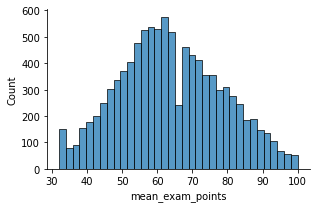

In [27]:
# распределение целевой переменной
sns.displot(train['mean_exam_points'], height=3, aspect=1.5)
plt.show()

Распределение целевой переменной похоже на нормальное

Unique values: [40. 48. 39. 46. 43. 33. 53. 60. 49. 34. 50. 42. 45. 54. 57. 52. 58. 55.
 44. 35. 41. 47. 51. 56. 63. 31. 38. 65. 66. 36. 64. 62. 68. 32. 30. 37.
 23. 29. 59. 24. 61. 28. 27. 26. 67. 25.]
Unique values amount: 46


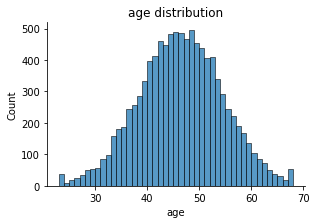

In [28]:
# возраст преподавателя
overview('age')

Дискретный признак, на вид распределен нормально

Unique values: [ 0.  4.  5.  1.  3.  2.  6.  8.  7. 10.  9.]
Unique values amount: 11


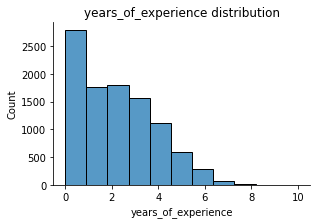

In [29]:
# опыт работы
overview('years_of_experience', bins=11)

Похоже, что готовить к ЕГЭ идут молодые преподаватели.
Признак дискретный, распределен не нормально

Unique values: [1400. 2850. 1200. 1500. 1650. 2100. 1800. 1750. 1150. 1300. 2300. 2600.
 1550. 1850.  300. 2400. 2200. 1600. 2750. 2250. 1250. 2800. 1350. 1000.
 1950. 1450. 2500. 2050. 1050. 1700. 2950. 1100. 2000. 3100. 2150.  950.
 2550. 2650. 1900.  850. 3050. 3200. 2450. 3150. 3300.  600. 2700.  800.
  750. 3350. 3000. 2350.  500. 2900. 3250. 3400.  900.  700. 3450.  450.
 3700. 3600.  650.  550. 3950. 3750. 3500.  350.  200. 3550.  400.  250.
 3800. 3650.]
Unique values amount: 74


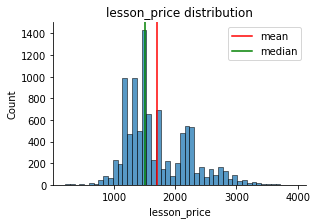

In [30]:
# стоимость занятия
overview('lesson_price', show_stats=True)

Потенциально непрерывный признак, хоть и представлен дискретными значениями. Распределен не нормально.

Unique values: [1. 3. 2. 4.]
Unique values amount: 4


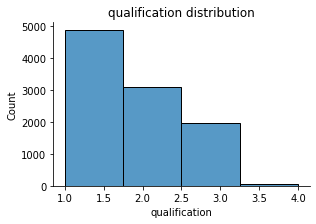

In [31]:
# квалификация преподавателя
overview('qualification', bins=4)

Признак дискретный, распределен не нормально. Возможно, он был категориальным.<br>
Можно попробовать использовать как ранг, где 1 - нисшее, 4 - высшее значение.<br>
Возможно, есть смысл объединить 3 и 4 квалификации, т.к. в 4ой очень мало значений

Остальные признаки бинарные

In [32]:
# разделяем на числовые, категориальные и бинарные признаки - вдруг пригодится
continuous = ['lesson_price']
discrets = ['age', 'years_of_experience', 'qualification']
binaries = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']

Correlations

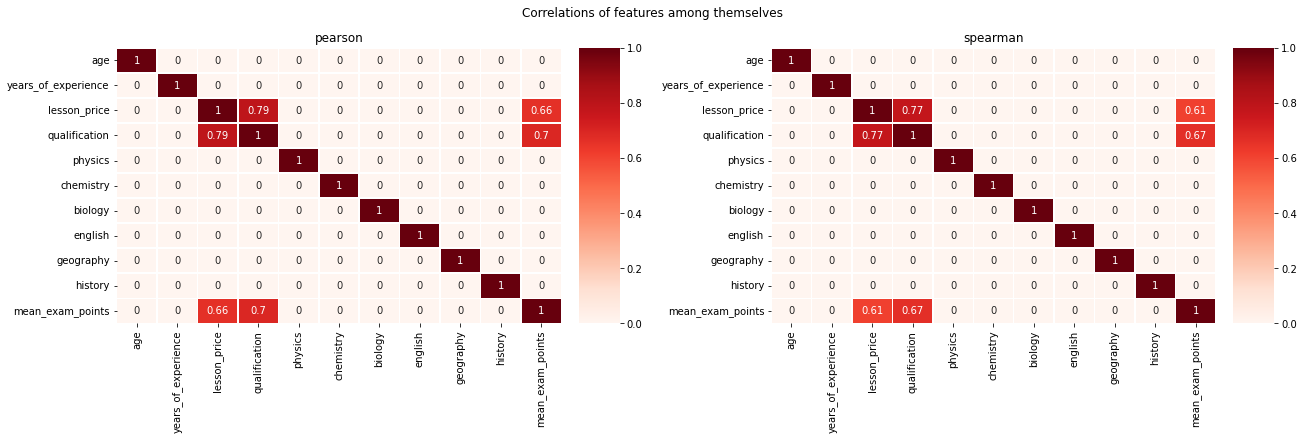

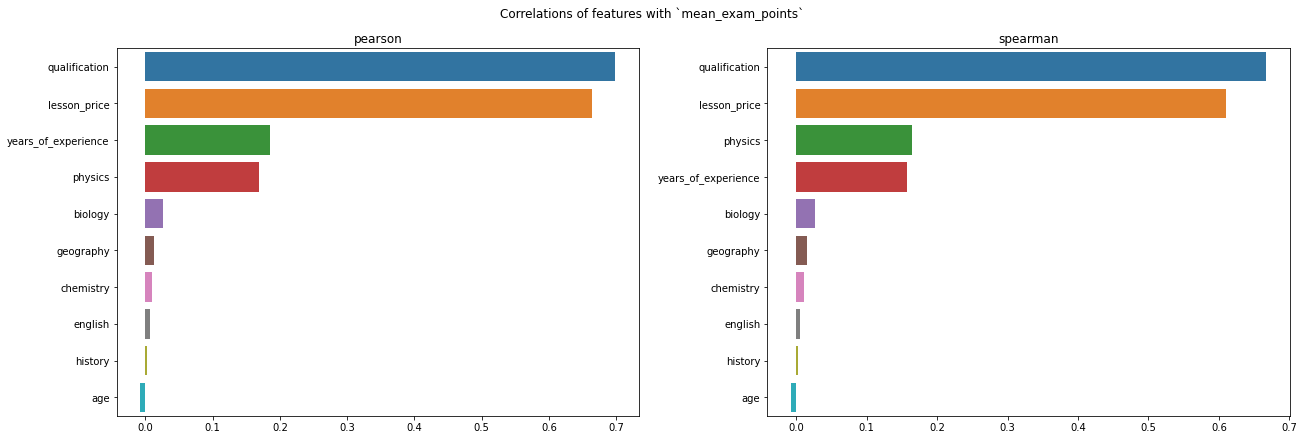

In [33]:
correlation_matrix(train, threshold=0.35)
correlations_target(train, target)

Наблюдается сильно выраженная положительная линейная зависимость между стоимостью занятия и квалификацией, а также их линейная связь с целевой переменной

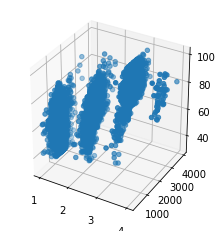

In [34]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(train['qualification'], train['lesson_price'], train[target])
plt.show()

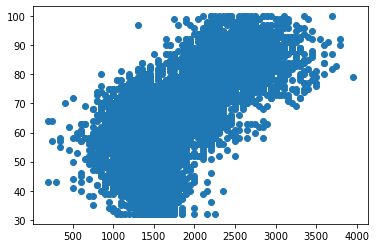

In [35]:
plt.scatter(train['lesson_price'], train[target])
plt.show()

# Preprocessing

In [36]:
class Preprocessing:
  def __init__(self, **kwargs):
    pass
    
  def fit(self, X, y=None):
    pass
  
  def transform(self, X, **kwargs):
    X = X.copy()

    return X

# Featuring

In [37]:
class Featuring:
  def __init__(self, **kwargs):
    """
    :param standardize - стандартизировать все признаки
    :param group - список аггрегирования {field: [group_by_fields]}
    :param drop - колонки для удаления
    """
    self.standardize = kwargs.get('standardize', False)
    self.group_feats = kwargs.get('group', [])
    self.y_group_feats = kwargs.get('group_y', [])
    self.drop_columns = kwargs.get('drop', [])
    self.deferred = []
    self.subjects = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']
    # for feat_dict in self.group_feats:
    #   for mfeat, gfeat in feat_dict.items():
    #     feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
    #     setattr(self, feat_name.replace(' ', '_'), None)
  
  def fit(self, X, y=None):
    X = X.copy()
    X['subjects'] = X[self.subjects].apply(lambda row: row.sum(), axis=1)
    # ---------- GROUP FEATURES AGGREGATE ----------
    if y is not None:
      X[y.name] = y      
      # средняя цена на 1 балл
      X['price per exam point'] = X['lesson_price'] / y
      # self.subjects_correlation = X[self.subjects].corrwith(y)

    for feat_dict in self.group_feats:
      for mfeat, gfeat in feat_dict.items():
        try:
          feat = X.groupby(gfeat)[mfeat].agg('median')
          feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
          setattr(self, feat_name.replace(' ', '_'), feat)
        except KeyError:
          if mfeat != y.name:
            self.deferred.append({mfeat: gfeat})
    

  def transform(self, X):
    X = X.copy()
    # объединение 3 и 4 квалификаций
    X.loc[X['qualification'] == 4, 'qualification'] = 3

    # кол-во преподаваемых предметов    
    X['subjects'] = X[self.subjects].apply(lambda row: row.sum(), axis=1)
    # взвешенное кол-во преподаваемых предметов
    # subj_weights = self.subjects_correlation / self.subjects_correlation.max()
    # X['weighted subjects'] = X[self.subjects].apply(lambda row: (row * subj_weights).sum(), axis=1)

    # возраст начала карьеры
    X['start career'] = X['age'] - X['years_of_experience']
    # отношение опыта работы к возрасту
    X['career rate'] = (X['years_of_experience'] + 1) / X['age']

    X['price per qualification point'] = X['lesson_price'] / X['qualification']
    # X['price rate'] = X['lesson_price'] * X['qualification'] * X['career rate']
    X['inversed price rate'] = X['lesson_price'] / (X['qualification'] * X['career rate'])

    # X['price per experience'] = X['lesson_price'] / (X['years_of_experience'] + 1)    
    # X['price per subject'] = X['lesson_price'] / (X['subjects'] + 1)

    # ----------- AGGREGATE DEFERRED -----------
    for deferred_dict in self.deferred:
      for mfeat, gfeat in deferred_dict.items():
        try:
          feat = X.groupby(gfeat)[mfeat].agg('median')
          feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
          setattr(self, feat_name.replace(' ', '_'), feat)
        except KeyError:
          print(f'Key error on feature: {mfeat}: {gfeat}')

    # ---------- GROUP FEATURES MERGE ----------
    for feat_dict in self.group_feats:
      for mfeat, gfeat in feat_dict.items():
        feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
        feat = getattr(self, feat_name.replace(' ', '_'), None)
        if feat is not None:
          X.loc[:, feat_name] = X[gfeat].join(feat, on=gfeat)[mfeat]
          X[feat_name].fillna(X[feat_name].median(), inplace=True)
          if self.standardize:
            X.loc[:, feat_name] = X[[feat_name]].apply(standard_scaler)


    if self.standardize:
      # масштабируем значения для линейной модели
      for col in X.columns:
        X.loc[:, col] = X[[col]].apply(standard_scaler)
      # добавляем intercept
      X.insert(0, 'w0', 1)

    # drop columns    
    drop_columns = [col for col in X.columns if (col in self.drop_columns)]
    X.drop(columns=drop_columns, inplace=True)
    return X

# Data preparation

In [38]:
# reload datasets
train = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1fWnxen_tC0qzj1ROKckIVm6BoQbs0h6i').drop(columns='Id')
test = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1MiOwUfe0QspbGbQMePEWRYKoXS8EFzwC').drop(columns='Id')
submission = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1tiVoYbcC0OSZ31e2Joz-OuUNtSwjYl1y')
target = 'mean_exam_points'

In [39]:
def prepare_data(X_train_src, y_train_src, X_test_src=None, pre={}, feat={}, **params):
  """ Prepare datasets """
  X_train = X_train_src.copy()
  y_train = y_train_src.copy()
  if X_test_src is not None:
    X_test = X_test_src.copy()

  # Preprocessing
  preprocessor = Preprocessing(**pre)
  preprocessor.fit(X_train)
  X_train = preprocessor.transform(X_train)
  if X_test_src is not None:
    X_test = preprocessor.transform(X_test)

  # Featuring
  featuring = Featuring(**feat)
  featuring.fit(X_train, y_train)
  X_train = featuring.transform(X_train)
  if X_test_src is not None:
    X_test = featuring.transform(X_test)
  
  return (X_train, X_test) if X_test_src is not None else X_train

# Features correlation

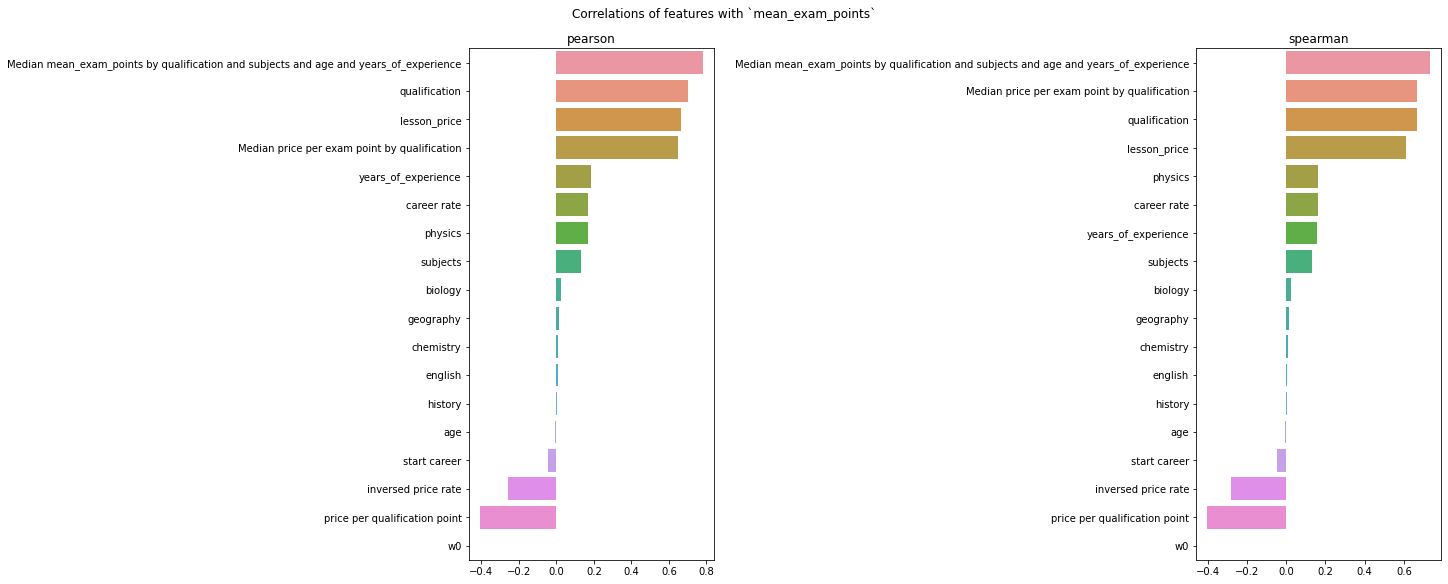

In [40]:
pre_params = {}
feat_params = {'standardize': True,
               'group': [#{'lesson_price': ['years_of_experience', 'qualification']},
                         #{'career rate': ['qualification', 'subjects']},
                         #{'years_of_experience': ['qualification', 'subjects']},
                        #  {'mean_exam_points': ['years_of_experience', 'qualification']},

                         {'price per exam point': ['qualification']}, # оставим этот
                        #  {'price per exam point': ['years_of_experience']},
                        #  {'price per exam point': ['subjects']},
                        #  {'price per exam point': ['age']},
                        #  {'price per exam point': ['qualification', 'years_of_experience']},
                        #  {'price per exam point': ['qualification', 'subjects']},
                        #  {'price per exam point': ['qualification', 'age']},
                        #  {'price per exam point': ['qualification', 'years_of_experience', 'subjects']},
                        #  {'price per exam point': ['qualification', 'years_of_experience', 'age']},
                        #  {'price per exam point': ['qualification', 'subjects', 'age']},
                        #  {'price per exam point': ['qualification', 'years_of_experience', 'subjects', 'age']},

                        #  {'inversed price rate': ['qualification']}
                         
                        #  {'mean_exam_points': ['years_of_experience']},
                        #  {'mean_exam_points': ['qualification']},
                        #  {'mean_exam_points': ['age']},
                        #  {'mean_exam_points': ['subjects']},
                        #  {'mean_exam_points': ['qualification', 'age']},
                        #  {'mean_exam_points': ['years_of_experience', 'age']},
                        #  {'mean_exam_points': ['years_of_experience', 'qualification', 'age']},
                        #  {'mean_exam_points': ['years_of_experience', 'qualification', 'subjects']},
                        #  {'mean_exam_points': ['qualification', 'subjects']},
                        #  {'mean_exam_points': ['qualification', 'subjects', 'age']},
                         {'mean_exam_points': ['qualification', 'subjects', 'age', 'years_of_experience']},

                         # {'years_of_experience': ['qualification']},    # a bit less than #3
                         # {'lesson_price': ['years_of_experience', 'qualification', 'subjects']},    # same as #1
                        #  {'age': ['subjects', 'qualification']},
                        #  {'years_of_experience': ['subjects']},
                        #  {'lesson_price': ['subjects']},
                        #  {'lesson_price': ['start career', 'subjects']},
                         ],
              #  'drop': ['age', 'chemistry',   'biology',  'english',  'geography',    'history']
              #  'drop': ['career rate', 'start career', 'age', 'chemistry',    'biology',  'english',  'geography',    'history']
              #  'drop': ['career rate', 'start career', 'age', 'chemistry',    'biology',  'english',  'geography',    'history']
               }

# отсмотр синтезированных признаков на линейную зависимость
check_correlations = prepare_data(train.drop(columns=target), train[target], pre=pre_params, feat=feat_params)
check_correlations[target] = train[target]
correlations_target(check_correlations, target, size=(20, 8))

In [41]:
check_correlations.head()

,w0,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,subjects,start career,career rate,price per qualification point,inversed price rate,Median price per exam point by qualification,Median mean_exam_points by qualification and subjects and age and years_of_experience,mean_exam_points
0,1,-0.730737,-1.121084,-0.569847,-0.914935,1.290930,-0.391477,-0.350825,-0.238205,5.490868,-0.140648,1.709215,-0.478480,-1.025255,0.966966,1.592467,-0.997652,-0.298987,61
1,1,0.263801,1.135981,2.192654,1.646116,1.290930,-0.391477,-0.350825,-0.238205,-0.182102,-0.140648,0.371068,0.013379,0.913147,-0.457980,-0.845734,1.336963,1.705550,76
2,1,-0.855055,-1.121084,-0.950881,-0.914935,-0.774558,-0.391477,-0.350825,-0.238205,-0.182102,-0.140648,-0.967079,-0.601444,-1.009559,0.333656,1.113980,-0.997652,-1.109332,53
3,1,0.015167,1.700247,-0.569847,-0.914935,-0.774558,-0.391477,-0.350825,-0.238205,-0.182102,-0.140648,-0.967079,-0.355515,1.556324,0.966966,-0.761826,-0.997652,-1.279931,54
4,1,-0.357785,-0.556818,-0.379330,-0.914935,-0.774558,-0.391477,-0.350825,-0.238205,-0.182102,-0.140648,-0.967079,-0.232550,-0.498541,1.283621,0.357243,-0.997652,-0.768134,57


# Linear model

In [42]:
# периодически пробуем линейную модель
cvfrac = 0.3
split_rs = 17

# linear params
pre_params = {}
feat_params = {'standardize': True,
               'group': [#{'lesson_price': ['years_of_experience', 'qualification']},
                         #{'career rate': ['qualification', 'subjects']},
                         #{'years_of_experience': ['qualification', 'subjects']}
                        #  {},
                         {'mean_exam_points': ['qualification', 'subjects', 'age', 'years_of_experience']},
                         {'price per exam point': ['qualification']},
                         
                         ],
               'drop': ['inversed price rate', 'career rate', 'start career', 'age', 'chemistry',	'biology',	'english',	'geography',	'history']
               }

# prepare whole train df for additional validation and dataset for final predictions
lm_X_whole_valid, lm_X_test = prepare_data(train.drop(columns=target), train[target], test, pre=pre_params, feat=feat_params)
y_whole_valid = train[target]

# get part of the main dataset for final hold-out validation
lm_X_train, lm_X_valid, y_train, y_valid = train_test_split(train.drop(columns=target), train[target], test_size=cvfrac, random_state=split_rs)
lm_X_train, lm_X_valid = prepare_data(lm_X_train, y_train, lm_X_valid, pre=pre_params, feat=feat_params)

In [43]:
lm_X_test.head()

,w0,years_of_experience,lesson_price,qualification,physics,subjects,price per qualification point,Median mean_exam_points by qualification and subjects and age and years_of_experience,Median price per exam point by qualification
0,1,0.571977,-1.234296,-0.900106,-0.785004,0.359216,-0.157797,-0.481549,-0.979690
1,1,0.571977,0.291657,0.377002,-0.785004,-0.974671,-0.558798,0.058956,0.714293
2,1,-0.549547,-0.280575,-0.900106,1.273752,0.359216,1.446209,-0.391465,-0.979690
3,1,2.254262,2.294470,1.654111,1.273752,1.693102,-0.425131,1.680469,1.350353
4,1,1.132739,2.771331,1.654111,1.273752,0.359216,-0.157797,1.995763,1.350353


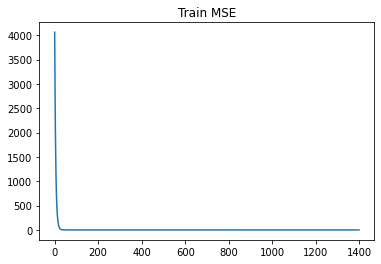

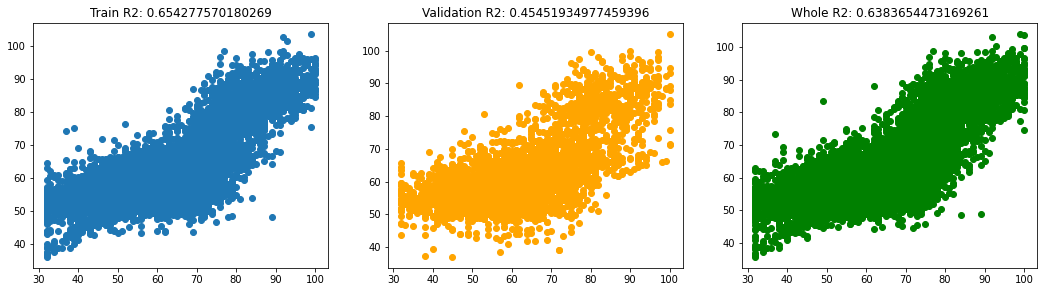

In [44]:
lm = LinearModel(model_type='regress')
lm.fit(lm_X_train, y_train, eta=1e-1, max_iterations=100, batch_type='random', batch_size=500, random_state=14)
# lm.fit(lm_X_train, y_train, eta=0.1, max_iterations=100, batch_type='random', batch_size=lm_X_train.shape[0], random_state=14, silent=False)
# lm.fit(X_train, y_train, eta=2.5e-3, max_iterations=200, batch_type='', batch_size=3500)

pred_train = lm.predict(lm_X_train)
pred_valid = lm.predict(lm_X_valid)
whole_pred = lm.predict(lm_X_whole_valid)

# результаты обучения
plt.title('Train MSE')
plt.plot(lm.errors)
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(18, 4.5))
ax[0].set_title(f'Train R2: {Metrics.R2(pred_train, y_train)}')
ax[0].scatter(y_train, pred_train)
ax[1].set_title(f'Validation R2: {Metrics.R2(pred_valid, y_valid)}')
ax[1].scatter(y_valid, pred_valid, color='orange')
ax[2].set_title(f'Whole R2: {Metrics.R2(whole_pred, y_whole_valid)}')
ax[2].scatter(y_whole_valid, whole_pred, color='green')
plt.show()

In [45]:
submission[target] = lm.predict(lm_X_test).values
submission.to_csv('submissions.csv', index=False)
submission.isna().any()

Id                  False
mean_exam_points    False
dtype: bool

In [46]:
submission

,Id,mean_exam_points
0,10000,55.929092
1,10001,64.025725
2,10002,59.358103
3,10003,88.443793
4,10004,94.243995
...,...,...
9995,19995,52.078403
9996,19996,78.034209
9997,19997,52.706315
9998,19998,63.088363


# Experiment

In [47]:
cvfrac = 0.3
split_rs = 17
pre_params = {}

# tree params
feat_params = {'standardize': True,   # в листе нет своего "стандартизатора"
               'group': [{'lesson_price': ['years_of_experience', 'qualification']},
                         {'career rate': ['qualification', 'subjects']},
                         {'years_of_experience': ['qualification', 'subjects']},
                         {'mean_exam_points': ['years_of_experience', 'qualification']},
                         {'price per exam point': ['qualification']},
                         ],
               'drop': ['w0', 'years_of_experience', 'start career', 'age', 'chemistry', 'biology', 'english', 'geography', 'history']
               }

# prepare whole train df for additional validation and dataset for final predictions
X_whole_valid, X_test = prepare_data(train.drop(columns=target), train[target], test, pre=pre_params, feat=feat_params)
y_whole_valid = train[target]

# get part of the main dataset for final hold-out validation
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(columns=target), train[target], test_size=cvfrac, random_state=split_rs)
X_train, X_valid = prepare_data(X_train, y_train, X_valid, pre=pre_params, feat=feat_params)

540281.0241185338


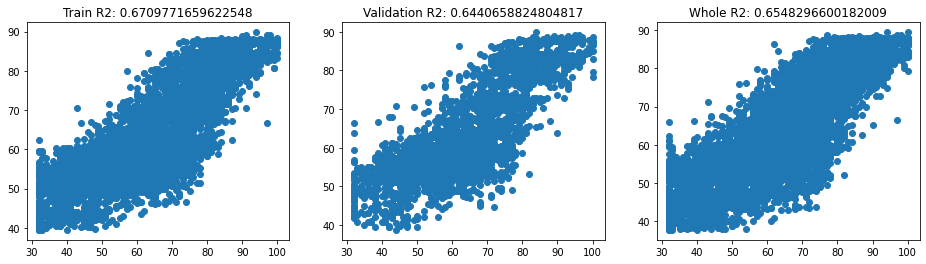

In [56]:
# 0.98210 without linear leaf | 0.97405 with linear leaf
# regressor = RegressRandomForest(basic_tree_class=BoostedRegressTree)
regressor = RegressRandomForest(basic_tree_class=BoostedRegressTree, basic_tree_params={'predictor': Predictor(13).regress_linear})
oob = regressor.fit(X_train, y_train,
                    eta=0.25, boost=17, boost_depth=3,
                    trees=9, min_samples_leaf=15, boost_metric=Metrics.R2, boost_data=(X_valid, y_valid), random_state=12)

print(oob)
train_pred = regressor.predict(X_train)
valid_pred = regressor.predict(X_valid)
whole_pred = regressor.predict(X_whole_valid)

# result vizualization
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title(f'Train R2: {Metrics.R2(train_pred, y_train)}')
ax[0].scatter(y_train, train_pred)
ax[1].set_title(f'Validation R2: {Metrics.R2(valid_pred, y_valid)}')
ax[1].scatter(y_valid, valid_pred)
ax[2].set_title(f'Whole R2: {Metrics.R2(whole_pred, y_whole_valid)}')
ax[2].scatter(y_whole_valid, whole_pred)
plt.show()

# Final predictions

In [58]:
# Final predictions
submission[target] = regressor.predict(X_test)
# submission[target] = np.round(regressor.predict(X_test))
submission.to_csv('submissions.csv', index=False)
submission.isna().any()

Id                  False
mean_exam_points    False
dtype: bool

In [53]:
submission

,Id,mean_exam_points
0,10000,55.483072
1,10001,62.949997
2,10002,51.127803
3,10003,88.624242
4,10004,89.072109
...,...,...
9995,19995,45.712889
9996,19996,80.410678
9997,19997,54.071743
9998,19998,61.715628
